In [3]:
%pylab inline

from keras.models import Sequential
from keras.layers import *
from keras.utils import np_utils
from imgUtils import *
from mailsUtils import send_mail
import time
import pandas as pd
import sys
import matplotlib.pyplot as plt
import numpy as np
import copy
import theano
import pylab as pl

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy', 'maximum', 'random', 'dot', 'multiply', 'add', 'concatenate', 'average']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Define model

In [ ]:
np.random.seed(123)  # for reproducibility
imgU = ImgUtils("./dataset", 10000)
start = time.strftime("%c")
theTrueScore = []
nb_classes = imgU.discover_and_make_order()
N_EPOCHS = 5

# Define model architecture
model = Sequential()

model.add(Convolution2D(nb_filter=64, nb_row=3, nb_col=3, input_shape=(256, 256, 3),
                        dim_ordering='tf'))
convout1 = Activation('relu')
model.add(convout1)
model.add(Convolution2D(nb_filter=32, nb_row=3, nb_col=3))
convout2 = Activation('relu')
model.add(convout2)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Discovering dataset...
2 classes found.
 1251 images found.
Shuffling order...
Ready for loading!
 938 for training and 312 for testing


/usr/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(data_format="channels_last", filters=64, kernel_size=(3, 3), input_shape=(256, 256,...)`
/usr/lib/python3.5/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=32, kernel_size=(3, 3))`


In [ ]:
redo = True
for i in range(0, N_EPOCHS):
    print("epoch", i)
    while redo:
        redo, x_train, y_train = imgU.load_dataset()
        # Preprocessing
        x_train = x_train.astype('float32')
        x_train /= 255

        y_train = np_utils.to_categorical(y_train, nb_classes)

        # Fit model on training data
        print("Starting...")
        model.fit(x_train, y_train, batch_size=32, nb_epoch=1, verbose=0)
        # TODO: Maybe this is the wrong order of how to apply epochs -> investigate
    redo = True

print("Train completed! Will now evalutate...")

epoch 0
Loaded all imgs for training. Next call will load test data...
Loading completed!
Starting...


/usr/lib64/python3.5/site-packages/keras/models.py:834: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


In [4]:
# Evaluate
redo = True
while redo:
    redo, x_test, y_test = imgU.load_dataset()
    # Preprocessing
    x_test = x_test.astype('float32')
    x_test /= 255

    y_test_2 = np_utils.to_categorical(y_test, nb_classes)
    # Evaluate model on test data
    theTrueScore.append(model.evaluate(x_test, y_test_2, batch_size=32, verbose=0))
    
print(theTrueScore)

Loaded all imgs for test. Done! Next call will load train data
Loading completed!
313/313 [==============================] - 28s     
[[0.13950929459862815, 0.96805111954387379]]


### Confusion matrix

In [5]:
y_hat = model.predict_classes(x_test)
print(y_hat)
pd.crosstab(y_hat, y_test)

313/313 [==============================] - 29s     
[0 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0
 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1
 0 0 1 0 0 1 0 1 1 1 0 1 0 1 0 0 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 0 1 0
 1 1 0 1 1 0 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1
 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 0 0 0
 0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 1 1 0 1 0
 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 1

col_0    0    1
row_0          
0      156    4
1        6  147

### Wrong predicted results
As it's pretty straightforward with minst, with leaves we have a hard time knowing why a class wasn't correctly predicted unless we are some kind of leaves expert. So we have to look deeper into our CNN and see how the activation map works so we know if the keys features are within the leaves or somewhere else (in this case that could be a biais).

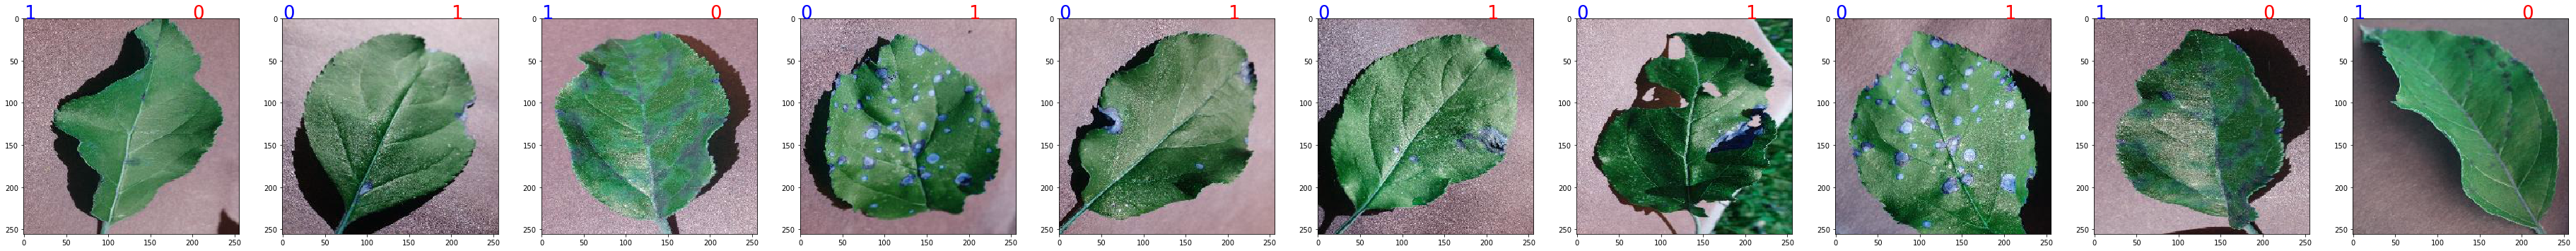

In [6]:
test_wrong = [im for im in zip(x_test,y_hat,y_test) if im[1] != im[2]]

plt.figure(figsize=(50, 50))
for ind, val in enumerate(test_wrong[:100]):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.subplot(10, 10, ind + 1)
    plt.text(0, 0, val[2], fontsize=26, color='blue')
    plt.text(200, 0, val[1], fontsize=26, color='red')
    plt.imshow(val[0])

### Visualizing convolution weights
First let's look at what does our model look like so far:

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 254, 254, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 252, 32)      18464     
_________________________________________________________________
activation_2 (Activation)    (None, 252, 252, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 126, 126, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 508032)            0         
__________

Okay so this is a huuuuge model i definitly have to reduce it BUT what is interesting right now is the first two conv2d.

In [29]:
convout1_f = theano.function(model.inputs, [convout1.output])
convout2_f = theano.function(model.inputs, [convout2.output])

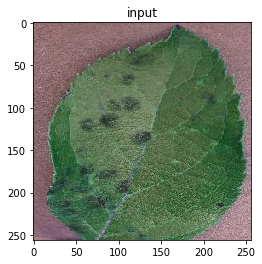

In [10]:
i = 10

# Visualize the first layer of convolutions on an input image
X = x_test[i:i+1]

plt.figure()
plt.title('input')
plt.imshow(np.squeeze(X))

C1 shape :  (254, 254, 64)


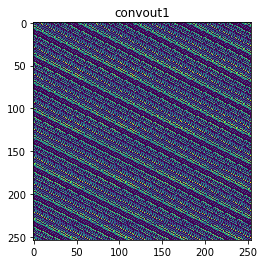

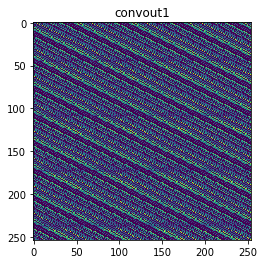

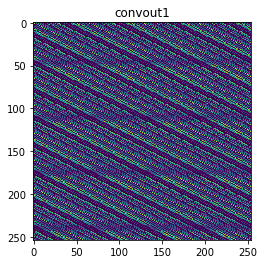

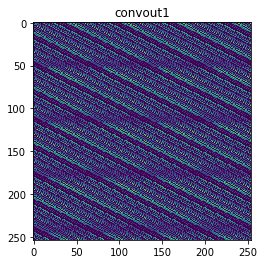

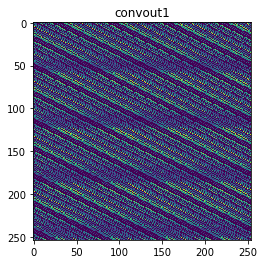

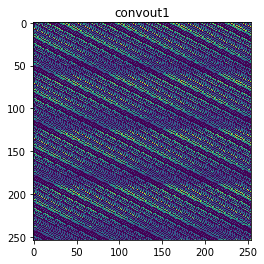

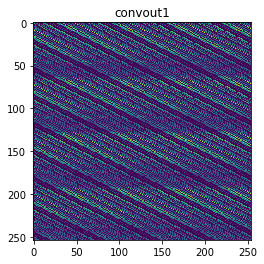

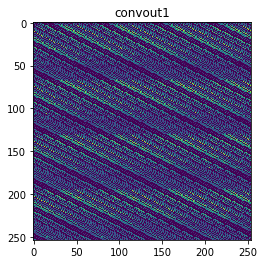

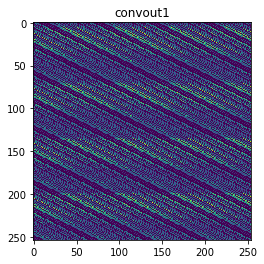

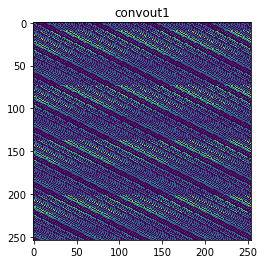

In [35]:
# Visualize convolution result (after activation)
C1 = convout1_f(X)
C1 = np.squeeze(C1)
print("C1 shape : ", C1.shape)
C1 = C1.reshape(64, 254, 254)
for img in C1[:10]:
    plt.figure()
    plt.title('convout1')
    plt.imshow(img)


C1 shape :  (252, 252, 32)


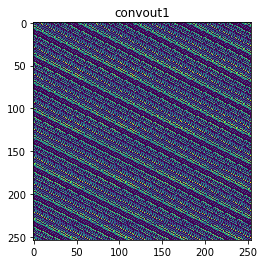

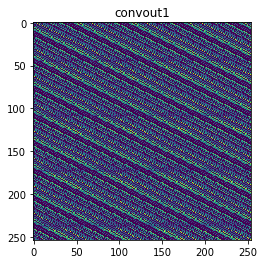

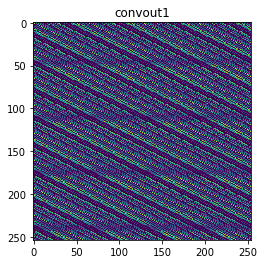

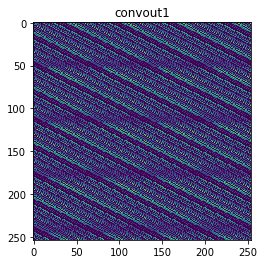

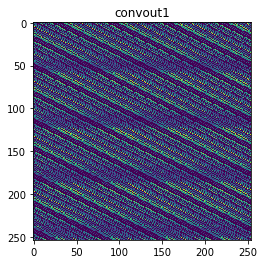

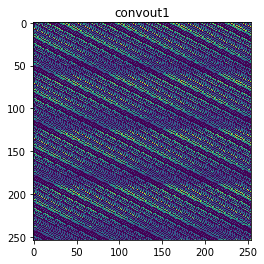

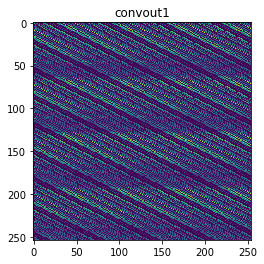

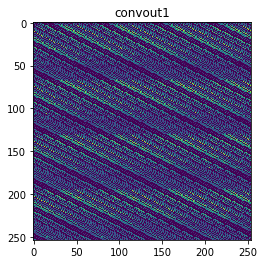

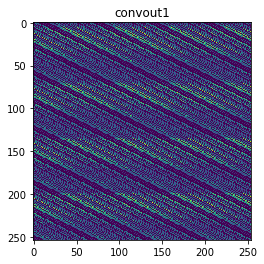

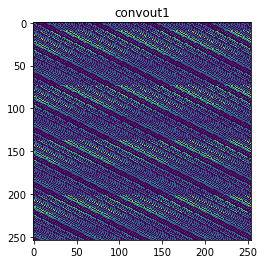

In [31]:
# Visualize convolution result (after activation)
C2 = convout2_f(X)
C2 = np.squeeze(C2)
print("C1 shape : ", C2.shape)
C2 = C2.reshape(32, 252, 252)
for img in C1[:10]:
    plt.figure()
    plt.title('convout1')
    plt.imshow(img)

In [ ]:
pl.figure(figsize=(15, 15))
pl.suptitle('convout1')
nice_imshow(pl.gca(), make_mosaic(C1,12, 12), cmap=cm.binary)